In [1]:
import sys
sys.path.insert(0, "../..")

In [2]:
import torch
from torch import nn
from torch.utils import data
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from copy import deepcopy
from collections import deque

from RegularizedNonlinearAcceleration.Python.rna_v2.online_rna import online_rna

In [2]:
torch.cuda.is_available()

True

In [3]:
train_ds = datasets.MNIST("../MNIST", download=True, train=True, transform=transforms.ToTensor())
test_ds = datasets.MNIST("../MNIST", download=True, train=False, transform=transforms.ToTensor())
valid_size = int(0.2 * len(train_ds))
train_ds, valid_ds = data.random_split(train_ds, [len(train_ds) - valid_size, valid_size])

train_loader = data.DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
valid_loader = data.DataLoader(valid_ds, batch_size=64, shuffle=True, num_workers=2)
test_loader = data.DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2)

In [4]:
model = nn.Sequential(
    nn.Conv2d(1, 32, 3),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(4*4*64, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(-1),
)
model.cuda()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=1024, out_features=128, bias=True)
  (12): ReLU()
  (13): Linear(in_features=128, out_features=10, bias=True)
  (14): LogSoftmax(dim=-1)
)

In [5]:
val_loss_fn = nn.NLLLoss(reduction="sum")

def validation(model, loader):
    ok = 0
    loss_sum = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.cuda()
            y = y.cuda()
            out = model(x)
            loss_sum += val_loss_fn(out, y)
            preds = out.argmax(1)
            ok += (y == preds).sum()
            total += len(y)
    return ok / total, loss_sum / total

def train_epoch(loss_log):
    model.train()
    for x, y in tqdm(train_loader):
        x = x.cuda()
        y = y.cuda()
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        loss_log.append(loss.item())
        optimizer.step()

In [6]:
validation(model, valid_loader)

(tensor(0.0954, device='cuda:0'), tensor(2.3046, device='cuda:0'))

## Without acceleration

In [7]:
initial_state = deepcopy(model.state_dict())
optimizer = online_rna(model.parameters(), 3e-3, acceleration_type="none")
loss_fn = nn.NLLLoss()

In [9]:
epochs = 40
without_acc = {"train_loss": [], "val_loss": [], "val_acc": []}

for epoch in range(epochs):
    print("Epoch", epoch+1)
    train_epoch(without_acc["train_loss"])
    val_acc, val_loss = validation(model, valid_loader)
    without_acc["val_loss"].append(val_loss)
    without_acc["val_acc"].append(val_acc)
    print(f"Validation accuracy: {val_acc:.4f}, validation loss: {val_loss:.4f}")

Epoch 1



Validation accuracy: 0.1106, validation loss: 2.2993
Epoch 2



Validation accuracy: 0.1217, validation loss: 2.2946
Epoch 3



Validation accuracy: 0.2158, validation loss: 2.2755
Epoch 4



Validation accuracy: 0.7148, validation loss: 0.9919
Epoch 5



Validation accuracy: 0.8777, validation loss: 0.4091
Epoch 6



Validation accuracy: 0.9121, validation loss: 0.2946
Epoch 7



Validation accuracy: 0.9243, validation loss: 0.2446
Epoch 8



Validation accuracy: 0.9392, validation loss: 0.1986
Epoch 9



Validation accuracy: 0.9515, validation loss: 0.1663
Epoch 10



Validation accuracy: 0.9552, validation loss: 0.1420
Epoch 11



Validation accuracy: 0.9635, validation loss: 0.1249
Epoch 12



Validation accuracy: 0.9668, validation loss: 0.1097
Epoch 13



Validation accuracy: 0.9695, validation loss: 0.1031
Epoch 14



Validation accuracy: 0.9731, validation loss: 0.0929
Epoch 15



Validation accuracy: 0.9725, validation loss: 0.0928
Epoch 16



Validation accuracy: 0.9742, validation loss: 0.0885
Epoch 17



Validation accuracy: 0.9736, validation loss: 0.0853
Epoch 18



Validation accuracy: 0.9745, validation loss: 0.0910
Epoch 19



Validation accuracy: 0.9786, validation loss: 0.0717
Epoch 20



Validation accuracy: 0.9738, validation loss: 0.0853
Epoch 21



Validation accuracy: 0.9788, validation loss: 0.0718
Epoch 22



Validation accuracy: 0.9783, validation loss: 0.0707
Epoch 23



Validation accuracy: 0.9757, validation loss: 0.0830
Epoch 24



Validation accuracy: 0.9808, validation loss: 0.0654
Epoch 25



Validation accuracy: 0.9799, validation loss: 0.0681
Epoch 26



Validation accuracy: 0.9819, validation loss: 0.0666
Epoch 27



Validation accuracy: 0.9819, validation loss: 0.0626
Epoch 28



Validation accuracy: 0.9826, validation loss: 0.0632
Epoch 29



Validation accuracy: 0.9802, validation loss: 0.0717
Epoch 30



Validation accuracy: 0.9823, validation loss: 0.0628
Epoch 31



Validation accuracy: 0.9839, validation loss: 0.0576
Epoch 32



Validation accuracy: 0.9827, validation loss: 0.0636
Epoch 33



Validation accuracy: 0.9835, validation loss: 0.0583
Epoch 34



Validation accuracy: 0.9835, validation loss: 0.0576
Epoch 35



Validation accuracy: 0.9834, validation loss: 0.0595
Epoch 36



Validation accuracy: 0.9839, validation loss: 0.0573
Epoch 37



Validation accuracy: 0.9838, validation loss: 0.0586
Epoch 38



Validation accuracy: 0.9829, validation loss: 0.0580
Epoch 39



Validation accuracy: 0.9834, validation loss: 0.0586
Epoch 40



Validation accuracy: 0.9848, validation loss: 0.0565


In [11]:
final_without_acc = deepcopy(model.state_dict())

## With acceleration, online scheme

In [10]:
model.load_state_dict(initial_state)
optimizer = online_rna(model.parameters(), 3e-3, K=10, reg_acc=1e-5, acceleration_type="online")

In [11]:
epochs = 15
with_acc = {"train_loss": [], "val_loss": [], "val_acc": []}

for epoch in range(epochs):
    print("Epoch", epoch+1)
    train_epoch(with_acc["train_loss"])

    optimizer.store(model=model)
    if(epoch == 1):
        optimizer.reset_buffers()
    if(epoch > 10):
        c = optimizer.accelerate()
    
    val_acc, val_loss = validation(model, valid_loader)
    with_acc["val_loss"].append(val_loss)
    with_acc["val_acc"].append(val_acc)
    print(f"Validation accuracy: {val_acc:.4f}, validation loss: {val_loss:.4f}")

Epoch 1



Validation accuracy: 0.1002, validation loss: 2.2963
Epoch 2



Validation accuracy: 0.2504, validation loss: 2.2483
Epoch 3



Validation accuracy: 0.8510, validation loss: 0.5136
Epoch 4



Validation accuracy: 0.9017, validation loss: 0.3276
Epoch 5



Validation accuracy: 0.9265, validation loss: 0.2390
Epoch 6



Validation accuracy: 0.9389, validation loss: 0.2024
Epoch 7



Validation accuracy: 0.9484, validation loss: 0.1681
Epoch 8



Validation accuracy: 0.9617, validation loss: 0.1339
Epoch 9



Validation accuracy: 0.9608, validation loss: 0.1315
Epoch 10



Validation accuracy: 0.9667, validation loss: 0.1105
Epoch 11



Validation accuracy: 0.9668, validation loss: 0.1060
Epoch 12


/home/michal/magister/rna/RegularizedNonlinearAcceleration/Python/rna_v2/online_rna.py:180: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370117127/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  param.data.add_(c,avg_model_hist[param][i])



Validation accuracy: 0.9744, validation loss: 0.0846
Epoch 13



Validation accuracy: 0.9764, validation loss: 0.0761
Epoch 14



Validation accuracy: 0.9762, validation loss: 0.0752
Epoch 15



Validation accuracy: 0.9777, validation loss: 0.0703


## With acceleration, offline scheme

In [20]:
model.load_state_dict(initial_state)
optimizer = online_rna(model.parameters(), 3e-3, K=10, reg_acc=1e-5, acceleration_type="offline")

In [21]:
epochs = 40
with_acc_offline = {"train_loss": [], "val_loss": [], "val_acc": []}
model_acc = deepcopy(model)

for epoch in range(epochs):
    print("Epoch", epoch+1)
    train_epoch(with_acc["train_loss"])

    optimizer.store(model=model)
    if(epoch == 1):
        optimizer.reset_buffers()
    else:
        c = optimizer.accelerate(model_acc)
    
    val_acc, val_loss = validation(model_acc, valid_loader)
    with_acc_offline["val_loss"].append(val_loss)
    with_acc_offline["val_acc"].append(val_acc)
    print(f"Validation accuracy: {val_acc:.4f}, validation loss: {val_loss:.4f}")

Epoch 1



Validation accuracy: 0.1106, validation loss: 2.2993
Epoch 2



Validation accuracy: 0.1106, validation loss: 2.2993
Epoch 3



Validation accuracy: 0.2089, validation loss: 2.2754
Epoch 4



Validation accuracy: 0.1218, validation loss: 2.2922
Epoch 5



Validation accuracy: 0.1585, validation loss: 2.2892
Epoch 6



Validation accuracy: 0.1657, validation loss: 2.2882
Epoch 7



Validation accuracy: 0.1989, validation loss: 2.2796
Epoch 8



Validation accuracy: 0.2418, validation loss: 2.2704
Epoch 9



Validation accuracy: 0.4069, validation loss: 2.2478
Epoch 10



Validation accuracy: 0.5484, validation loss: 2.2178
Epoch 11



Validation accuracy: 0.6947, validation loss: 2.1583
Epoch 12



Validation accuracy: 0.7872, validation loss: 2.0516
Epoch 13



Validation accuracy: 0.9710, validation loss: 0.0990
Epoch 14



Validation accuracy: 0.9733, validation loss: 0.0916
Epoch 15



Validation accuracy: 0.9751, validation loss: 0.0815
Epoch 16



Validation accuracy: 0.9760, validation loss: 0.0827
Epoch 17



Validation accuracy: 0.9778, validation loss: 0.0758
Epoch 18



Validation accuracy: 0.9788, validation loss: 0.0721
Epoch 19



Validation accuracy: 0.9787, validation loss: 0.0695
Epoch 20



Validation accuracy: 0.9799, validation loss: 0.0679
Epoch 21



Validation accuracy: 0.9801, validation loss: 0.0667
Epoch 22



Validation accuracy: 0.9805, validation loss: 0.0678
Epoch 23



Validation accuracy: 0.9812, validation loss: 0.0664
Epoch 24



Validation accuracy: 0.9814, validation loss: 0.0660
Epoch 25



Validation accuracy: 0.9822, validation loss: 0.0635
Epoch 26



Validation accuracy: 0.9830, validation loss: 0.0617
Epoch 27



Validation accuracy: 0.9828, validation loss: 0.0608
Epoch 28



Validation accuracy: 0.9826, validation loss: 0.0605
Epoch 29



Validation accuracy: 0.9823, validation loss: 0.0608
Epoch 30



Validation accuracy: 0.9818, validation loss: 0.0605
Epoch 31



Validation accuracy: 0.9830, validation loss: 0.0586
Epoch 32



Validation accuracy: 0.9834, validation loss: 0.0576
Epoch 33



Validation accuracy: 0.9840, validation loss: 0.0560
Epoch 34



Validation accuracy: 0.9840, validation loss: 0.0559
Epoch 35



Validation accuracy: 0.9837, validation loss: 0.0555
Epoch 36



Validation accuracy: 0.9843, validation loss: 0.0542
Epoch 37



Validation accuracy: 0.9841, validation loss: 0.0540
Epoch 38



Validation accuracy: 0.9843, validation loss: 0.0537
Epoch 39



Validation accuracy: 0.9846, validation loss: 0.0532
Epoch 40



Validation accuracy: 0.9849, validation loss: 0.0530


In [22]:
results = {
    "without_acc": without_acc,
    "with_acc_online": with_acc,
    "with_acc_offline": with_acc_offline,
}
torch.save(results, "first_nn_results_10.p")

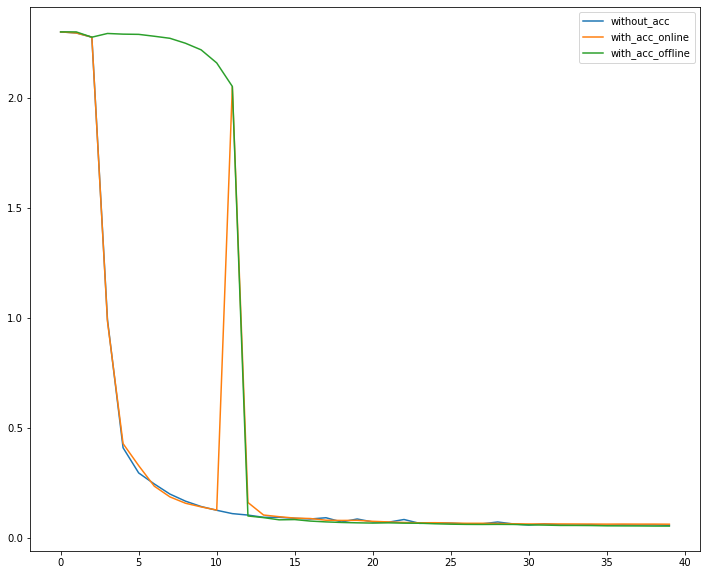

In [24]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 10))
x = np.arange(40)
for name, res in results.items():
    plt.plot(x, res["val_loss"], label=name)
plt.legend()

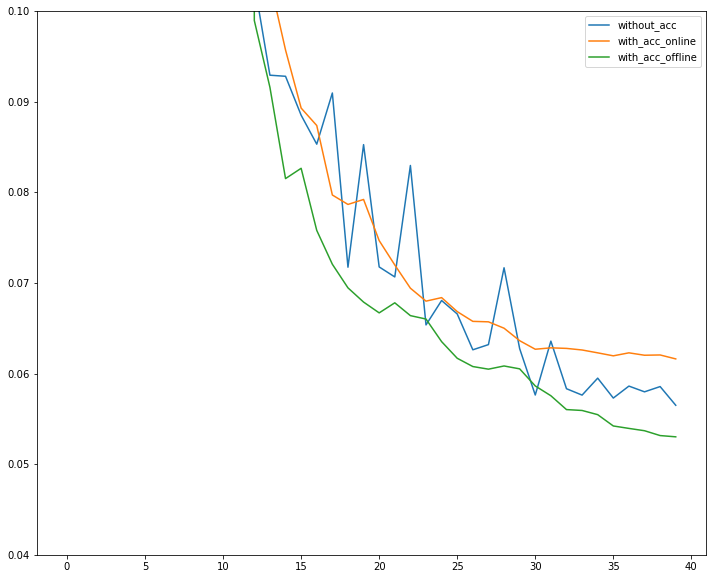

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
x = np.arange(40)
for name, res in results.items():
    plt.plot(x, res["val_loss"], label=name)
plt.ylim(0.04, 0.1)
plt.legend()